In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt

from scipy import randn

In [24]:
data = pd.read_csv('data/prices.txt')

In [25]:
data.head()

,area,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


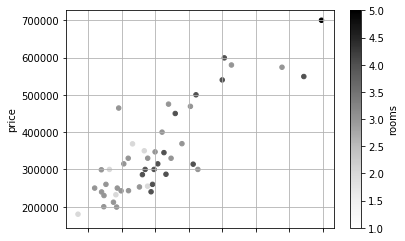

In [26]:
plot1 = data.plot(kind='scatter', x='area', y='price', c='rooms', grid=True)
#plot1.set_facecolor("gray")

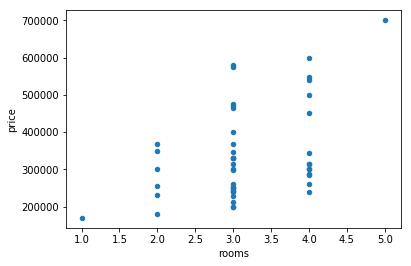

In [27]:
data.plot(kind = 'scatter', x = 'rooms', y='price')

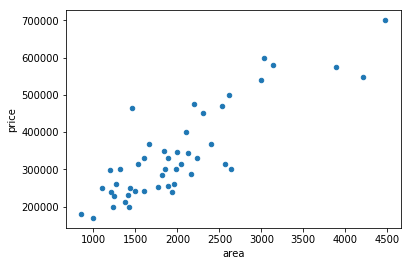

In [28]:
data.plot(kind = 'scatter', x = 'area', y='price')

In [29]:
X = data[['area', 'rooms']]
y = np.array(list(map(float, data['price'])))

In [30]:
def standard_transform(x):
    return StandardScaler().fit_transform(x)

def append_one(x):
    return np.append(np.ones(len(x)).reshape((len(x), 1)), x, axis=1)

In [31]:
scalerX = StandardScaler()
scalerY = StandardScaler()
initX = X
X = scalerX.fit_transform(X)
X = append_one(X)
initX = append_one(initX)

y = scalerY.fit_transform(y.reshape(len(y), 1)).reshape(len(y))


In [32]:
def first_price(p):    
    return scalerY.inverse_transform([p])[0]    
    
def get_mse(regressor, xs, ys):    
    predicted = np.apply_along_axis(regressor.predict, 1, xs)
    return sqrt((
        (scalerY.inverse_transform(predicted) - scalerY.inverse_transform(ys)) ** 2)
                .mean())


In [65]:
class LinearRegression:
    def __init__(self, w = None, linearCoef = 0.5, numIter = 100, eps = 1e-9):
        self.baseW = w
        self.linearCoef = linearCoef   
        self.numIter = numIter
        self.eps = eps
        
    def _grad_descend(self):
        Xt = self.X.transpose()
        m = self.X.shape[0]
        mse = None
        w = self.baseW
        error_ar = []
        for i in range(self.numIter):
            h = np.dot(self.X, w)
            diff = h - self.y
            grad = 2 * np.dot(Xt, diff) / m                        
            w -= (self.linearCoef[i] * grad)
            error_ar.append(self.linearCoef[i] * np.sum(grad ** 2))            
            if (self.linearCoef[i] * np.sum(grad ** 2) < self.eps):                
                break
            
        self.w = w
        
        fig = plt.figure()
        fig.add_subplot(1, 1, 1)    
        it_ar = list(range(len(error_ar)))                
        plt.scatter(list(it_ar), error_ar)
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self._grad_descend()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w


[ -6.61409461e-17   8.84767047e-01  -5.31691424e-02]
63926.2082625857
CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 105 ms


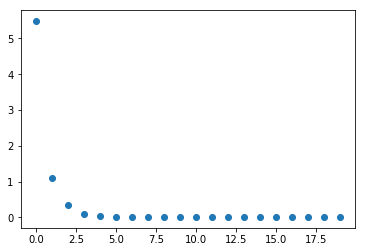

In [66]:
%%time

m, n = X.shape
w = np.ones(n)
numIter = 100
linearCoef = [0.5] * numIter
linearReg = LinearRegression(w = w, linearCoef = linearCoef, numIter = numIter)
linearReg.fit(X, y)

print (linearReg.weights())
print (get_mse(linearReg, X, y))

In [13]:
def show_separator(weights):
    tX = X.transpose()
    for i, x in enumerate(initX.transpose()[1:], 1):                
        plt.scatter(x, scalerY.inverse_transform(y)) 
        plt.plot([x.min(), x.max()], [first_price(weights[0] + weights[i] * tX[i].min()),
                                      first_price(weights[0] + weights[i] * tX[i].max())])      
        plt.ylabel('Price')
        plt.xlabel('%s' % ['area', 'rooms'][i-1])
        plt.show()

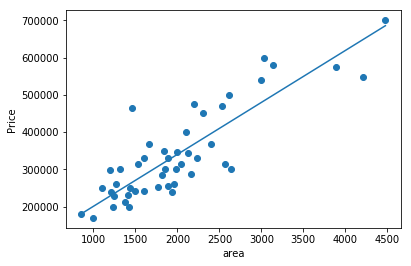

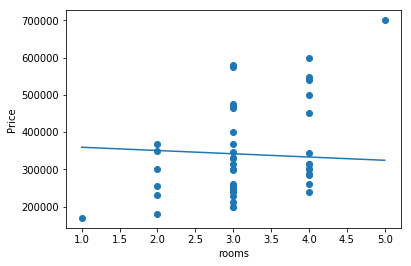

In [14]:
linW = linearReg.weights()
show_separator(linW)

In [15]:
np.random.seed(53)

class GeneticReg:
    def __init__(self, numIter = 100, popSize = 50, mutationCount = 5):        
        self.numIter = numIter
        self.popSize = popSize
        self.mutationCount = mutationCount        
        
    def mutation(self, pop):            
        return pop + (0.3 * randn(*pop.shape))
    
    def gen_optimize(self):
        m, n = self.X.shape
        pop = np.zeros((self.popSize, n))
        pops = []
        mses = []        
       
        for i in range(self.numIter):
            pops = pop.copy()
            for j in range(self.mutationCount):
                pops = np.append(pops, self.mutation(pop), axis=0)
                        
            mses = []
            for j, single_pop in enumerate(pops):
                h = np.dot(X, single_pop)
                diff = h - y
                mse = np.sum(diff ** 2) / (m)
                mses.append((mse, j))
            mses = sorted(mses)
            pop = pops[mses[0][1]].reshape(1, len(pops[mses[0][1]]))
            
            for _, j in mses[1:self.popSize]:
                pop = np.append(pop, pops[j].reshape(1, len(pops[j])), axis=0)                                    
        
        self.w = pops[mses[0][1]]
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self.gen_optimize()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w

In [16]:
'''
iterAr = [100, 500, 1000, 5000]
for ni in iterAr:
    mseGen = []
    for i in range(10):        
        genTest = GeneticReg(numIter = ni, popSize = 10, mutationCount = 5)
        genTest.fit(X, y)
        mseGen.append(get_mse(genTest, X, y))
    print ("Iter count: %d" % ni)
    print ("Average: %d" % np.mean(mseGen))
    print ("Minimum: %d" % np.min(mseGen))
    print ("Maximum: %d" % np.max(mseGen))
'''    

Iter count: 100
Average: 64026
Minimum: 63933
Maximum: 64088
Iter count: 500
Average: 63949
Minimum: 63928
Maximum: 63982
Iter count: 1000
Average: 63935
Minimum: 63927
Maximum: 63947
Iter count: 5000
Average: 63930
Minimum: 63926
Maximum: 63935


In [20]:
%%time

genReg = GeneticReg(numIter = 1000, popSize = 10, mutationCount = 5)
genReg.fit(X, y)
print (get_mse(genReg, X, y))
print (genReg.weights())

63940.47803954157
[ 0.00604623  0.88300852 -0.04321907]
CPU times: user 1.12 s, sys: 8 ms, total: 1.12 s
Wall time: 1.13 s


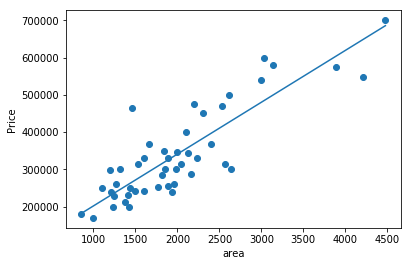

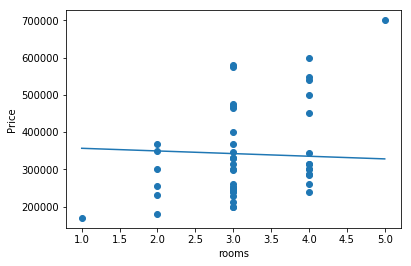

In [21]:
genW = genReg.weights()
show_separator(genW)

In [22]:
exX = [[2100., 3.]]
exX = append_one(scalerX.transform(exX))

print (first_price(linearReg.predict(exX)))
print (first_price(genReg.predict(exX)))

[ 355726.01353176]
[ 356168.17962675]
